In [10]:
import torch

print(f"Torch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA device: {torch.cuda.get_device_name(0)}")




Torch version: 2.5.1
CUDA available: True
CUDA device: NVIDIA GeForce RTX 3050 Laptop GPU


In [2]:
import pandas as pd
import torch
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
import torch.nn.functional as F
from torch_geometric.loader import NeighborLoader

movies = pd.read_csv('movies.csv')
ratings = pd.read_csv('ratings.csv')

user_ids = ratings['userId'].unique()
movie_ids = movies['movieId'].unique()

user_id_map = {user_id: i for i, user_id in enumerate(user_ids)}
movie_id_map = {movie_id: i + len(user_ids) for i, movie_id in enumerate(movie_ids)}

edges = []
edge_weights = []

for _, row in ratings.iterrows():
    user_node = user_id_map[row['userId']]
    movie_node = movie_id_map[row['movieId']]
    edges.append([user_node, movie_node])
    edges.append([movie_node, user_node])  
    edge_weights.append(row['rating'])
    edge_weights.append(row['rating'])

edges = torch.tensor(edges).t().contiguous()
edge_weights = torch.tensor(edge_weights, dtype=torch.float)

num_users = len(user_ids)
num_movies = len(movie_ids)
num_nodes = num_users + num_movies

feature_dim = 8
node_features = torch.eye(num_nodes, feature_dim)

data = Data(x=node_features, edge_index=edges, edge_attr=edge_weights)

class GCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.edge_predictor = torch.nn.Linear(hidden_channels, out_channels)

    def forward(self, x, edge_index, edge_attr):
        x = self.conv1(x, edge_index, edge_weight=edge_attr)
        x = F.relu(x)
        x = self.conv2(x, edge_index, edge_weight=edge_attr)

        row, col = edge_index  
        edge_features = x[row] + x[col]  
        edge_predictions = self.edge_predictor(edge_features)

        return edge_predictions


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

hidden_dim = 32
model = GCN(in_channels=feature_dim, hidden_channels=hidden_dim, out_channels=1).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.MSELoss()

data = data.to(device)

loader = NeighborLoader(
    data,
    num_neighbors=[10, 5],  
    batch_size=256,        
    shuffle=True
)

accumulation_steps = 2  
for epoch in range(20):  
    model.train()
    total_loss = 0
    for i, batch in enumerate(loader):
        batch = batch.to(device)
        optimizer.zero_grad()
        out = model(batch.x, batch.edge_index, batch.edge_attr)

        target = batch.edge_attr.view(-1, 1)
        loss = criterion(out, target)

        loss.backward() 
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {total_loss:.4f}")
model.eval()
with torch.no_grad():
    movie_embeddings = model(data.x, data.edge_index, data.edge_attr)[num_users:]
    user_embeddings = model(data.x, data.edge_index, data.edge_attr)[:num_users]

print("Model training completed.")


C:\Users\abhi9\anaconda3\envs\torch_env\lib\site-packages\torch_geometric\typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: [WinError 127] The specified procedure could not be found
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
C:\Users\abhi9\anaconda3\envs\torch_env\lib\site-packages\torch_geometric\typing.py:97: UserWarning: An issue occurred while importing 'torch-cluster'. Disabling its usage. Stacktrace: [WinError 127] The specified procedure could not be found
  warnings.warn(f"An issue occurred while importing 'torch-cluster'. "
C:\Users\abhi9\anaconda3\envs\torch_env\lib\site-packages\torch_geometric\typing.py:113: UserWarning: An issue occurred while importing 'torch-spline-conv'. Disabling its usage. Stacktrace: [WinError 127] The specified procedure could not be found
  warnings.warn(
C:\Users\abhi9\anaconda3\envs\torch_env\lib\site-packages\torch_geometric\typing.py:124: UserWarning: An is

Epoch 1, Loss: 113.0956
Epoch 2, Loss: 46.9774
Epoch 3, Loss: 46.2851
Epoch 4, Loss: 45.5311
Epoch 5, Loss: 45.2601
Epoch 6, Loss: 45.2318
Epoch 7, Loss: 44.9825
Epoch 8, Loss: 44.9876
Epoch 9, Loss: 44.6112
Epoch 10, Loss: 45.2141
Epoch 11, Loss: 45.1996
Epoch 12, Loss: 44.6970
Epoch 13, Loss: 45.2317
Epoch 14, Loss: 44.8790
Epoch 15, Loss: 45.2031
Epoch 16, Loss: 44.9350
Epoch 17, Loss: 45.0276
Epoch 18, Loss: 44.7627
Epoch 19, Loss: 45.0223
Epoch 20, Loss: 44.8939
Model training completed.


In [3]:
import numpy as np

def predict_ratings(model, data, user_id_map, movie_id_map, num_users, num_movies):
    model.eval()
    user_embeddings = model(data.x, data.edge_index, data.edge_attr)[:num_users]  
    movie_embeddings = model(data.x, data.edge_index, data.edge_attr)[num_users:]  
    predicted_ratings = torch.matmul(user_embeddings, movie_embeddings.T) 

    return predicted_ratings

def calculate_rmse(predicted_ratings, true_ratings, user_ids, movie_ids, user_id_map, movie_id_map):
    mse = 0
    count = 0

    for _, row in ratings.iterrows():
        user_node = user_id_map[row['userId']]
        movie_node = movie_id_map[row['movieId']]
        
        predicted_rating = predicted_ratings[user_node, movie_node].item()
        true_rating = row['rating']
        
        mse += (predicted_rating - true_rating) ** 2
        count += 1
    
    rmse = np.sqrt(mse / count)
    return rmse

predicted_ratings = predict_ratings(model, data, user_id_map, movie_id_map, num_users, num_movies)

rmse = calculate_rmse(predicted_ratings, ratings['rating'], ratings['userId'], ratings['movieId'], user_id_map, movie_id_map)
print(f"RMSE of the model: {rmse:.4f}")

def recommend_movies(model, data, user_id, top_k=10):
    model.eval()
    user_node = user_id_map[user_id]
    
    with torch.no_grad():
        movie_indices = torch.arange(num_users, num_nodes).to(device)  
        user_embedding = model(data.x, data.edge_index, data.edge_attr)[user_node]  
        movie_embeddings = model(data.x, data.edge_index, data.edge_attr)[movie_indices]  
        
        scores = torch.matmul(movie_embeddings, user_embedding)

    _, top_movie_indices = torch.topk(scores, top_k)
    recommended_movies = [movie_id_map_inv[i.item()] for i in top_movie_indices]
    return recommended_movies

movie_id_map_inv = {v: k for k, v in movie_id_map.items()}


user_id = 1  
recommended_movies = recommend_movies(model, data, user_id, top_k=10)
print(f"Top 10 recommended movies for User {user_id}: {recommended_movies}")


RMSE of the model: 7.4533
Top 10 recommended movies for User 1: [np.int64(73042), np.int64(73106), np.int64(4718), np.int64(4717), np.int64(73386), np.int64(73344), np.int64(72921), np.int64(72982), np.int64(6302), np.int64(6303)]


In [4]:
import pandas as pd
import torch
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
import torch.nn.functional as F
from torch_geometric.loader import NeighborLoader
from torch.optim.lr_scheduler import StepLR
import numpy as np

movies = pd.read_csv('movies.csv')
ratings = pd.read_csv('ratings.csv')

user_ids = ratings['userId'].unique()
movie_ids = movies['movieId'].unique()

user_id_map = {user_id: i for i, user_id in enumerate(user_ids)}
movie_id_map = {movie_id: i + len(user_ids) for i, movie_id in enumerate(movie_ids)}

edges = []
edge_weights = []

for _, row in ratings.iterrows():
    user_node = user_id_map[row['userId']]
    movie_node = movie_id_map[row['movieId']]
    edges.append([user_node, movie_node])
    edges.append([movie_node, user_node])  
    edge_weights.append(row['rating'])
    edge_weights.append(row['rating'])

edges = torch.tensor(edges).t().contiguous()
edge_weights = torch.tensor(edge_weights, dtype=torch.float)

num_users = len(user_ids)
num_movies = len(movie_ids)
num_nodes = num_users + num_movies

genre_features = pd.get_dummies(movies['genres']).values
movie_features = torch.tensor(genre_features, dtype=torch.float)
user_features = torch.zeros(num_users, genre_features.shape[1])  
node_features = torch.cat([user_features, movie_features], dim=0)

data = Data(x=node_features, edge_index=edges, edge_attr=edge_weights)

class GCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.bn1 = torch.nn.BatchNorm1d(hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.bn2 = torch.nn.BatchNorm1d(hidden_channels)
        self.edge_predictor = torch.nn.Linear(hidden_channels, out_channels)
        self.dropout = torch.nn.Dropout(p=0.5)  

    def forward(self, x, edge_index, edge_attr):
        x = self.conv1(x, edge_index, edge_weight=edge_attr)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.dropout(x)  
        x = self.conv2(x, edge_index, edge_weight=edge_attr)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.dropout(x)  

        row, col = edge_index
        edge_features = x[row] + x[col] 
        edge_predictions = self.edge_predictor(edge_features)

        return edge_predictions

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

hidden_dim = 16  
model = GCN(in_channels=node_features.shape[1], hidden_channels=hidden_dim, out_channels=1).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-5)  # L2 regularization
scheduler = StepLR(optimizer, step_size=10, gamma=0.7)

data = data.to(device)

loader = NeighborLoader(
    data,
    num_neighbors=[10, 5],  
    batch_size=64,          
    shuffle=True
)


accumulation_steps = 2  
best_val_loss = float('inf')
patience = 5
no_improvement = 0

for epoch in range(20): 
    model.train()
    total_loss = 0
    total_rmse = 0
    total_accuracy = 0
    for i, batch in enumerate(loader):
        batch = batch.to(device)
        optimizer.zero_grad()
        out = model(batch.x, batch.edge_index, batch.edge_attr)

        target = batch.edge_attr.view(-1, 1)
        loss = F.mse_loss(out, target)
        loss.backward()  
        optimizer.step()
        total_loss += loss.item()

        rmse = torch.sqrt(F.mse_loss(out, target)).item()
        total_rmse += rmse
        accuracy = (torch.abs(out - target) < 1.0).float().mean().item()
        total_accuracy += accuracy

    scheduler.step()

    val_loss = total_loss  

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        no_improvement = 0
    else:
        no_improvement += 1

    if no_improvement >= patience:
        print(f"Early stopping at epoch {epoch+1}")
        break

    print(f"Epoch {epoch+1}, Loss: {total_loss:.4f}, RMSE: {total_rmse/len(loader):.4f}, Accuracy: {total_accuracy/len(loader):.4f}")

model.eval()
with torch.no_grad():
    user_embeddings = model(data.x, data.edge_index, data.edge_attr)[:num_users]
    movie_embeddings = model(data.x, data.edge_index, data.edge_attr)[num_users:]

print("Model training completed.")


Epoch 1, Loss: 433.6266, RMSE: 1.5763, Accuracy: 0.4657
Epoch 2, Loss: 240.4682, RMSE: 1.2176, Accuracy: 0.5820
Epoch 3, Loss: 213.8275, RMSE: 1.1484, Accuracy: 0.6139
Epoch 4, Loss: 197.7593, RMSE: 1.1045, Accuracy: 0.6340
Epoch 5, Loss: 190.6372, RMSE: 1.0844, Accuracy: 0.6479
Epoch 6, Loss: 182.1661, RMSE: 1.0600, Accuracy: 0.6606
Epoch 7, Loss: 179.3291, RMSE: 1.0517, Accuracy: 0.6663
Epoch 8, Loss: 177.4081, RMSE: 1.0460, Accuracy: 0.6690
Epoch 9, Loss: 176.6753, RMSE: 1.0440, Accuracy: 0.6702
Epoch 10, Loss: 174.5950, RMSE: 1.0377, Accuracy: 0.6740
Epoch 11, Loss: 173.3771, RMSE: 1.0342, Accuracy: 0.6755
Epoch 12, Loss: 173.8220, RMSE: 1.0355, Accuracy: 0.6739
Epoch 13, Loss: 172.7627, RMSE: 1.0323, Accuracy: 0.6753
Epoch 14, Loss: 173.2862, RMSE: 1.0339, Accuracy: 0.6756
Epoch 15, Loss: 172.7648, RMSE: 1.0323, Accuracy: 0.6747
Epoch 16, Loss: 172.1664, RMSE: 1.0306, Accuracy: 0.6766
Epoch 17, Loss: 171.8637, RMSE: 1.0296, Accuracy: 0.6765
Epoch 18, Loss: 171.1849, RMSE: 1.0276, 

Epoch 1, Loss: 168.2520, RMSE: 1.0188, Accuracy: 0.6819
Epoch 2, Loss: 167.8061, RMSE: 1.0174, Accuracy: 0.6824
Epoch 3, Loss: 167.8680, RMSE: 1.0176, Accuracy: 0.6837
Epoch 4, Loss: 167.5208, RMSE: 1.0166, Accuracy: 0.6829
Epoch 5, Loss: 168.0628, RMSE: 1.0182, Accuracy: 0.6834
Epoch 6, Loss: 167.5509, RMSE: 1.0166, Accuracy: 0.6851
Epoch 7, Loss: 167.3104, RMSE: 1.0159, Accuracy: 0.6841
Epoch 8, Loss: 168.0952, RMSE: 1.0183, Accuracy: 0.6825
Epoch 9, Loss: 167.8535, RMSE: 1.0175, Accuracy: 0.6823
Epoch 10, Loss: 167.0713, RMSE: 1.0152, Accuracy: 0.6835
Epoch 11, Loss: 167.3300, RMSE: 1.0160, Accuracy: 0.6849
Epoch 12, Loss: 168.1076, RMSE: 1.0183, Accuracy: 0.6818
Epoch 13, Loss: 167.3144, RMSE: 1.0159, Accuracy: 0.6828
Epoch 14, Loss: 166.6312, RMSE: 1.0139, Accuracy: 0.6842
Epoch 15, Loss: 166.8698, RMSE: 1.0146, Accuracy: 0.6853
Epoch 16, Loss: 166.9166, RMSE: 1.0147, Accuracy: 0.6847
Epoch 17, Loss: 168.0190, RMSE: 1.0181, Accuracy: 0.6829
Epoch 18, Loss: 167.7083, RMSE: 1.0171, 

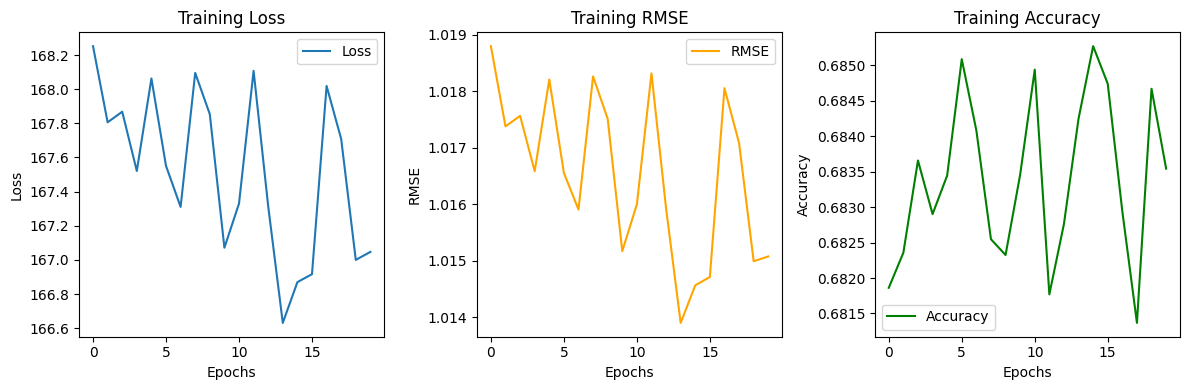

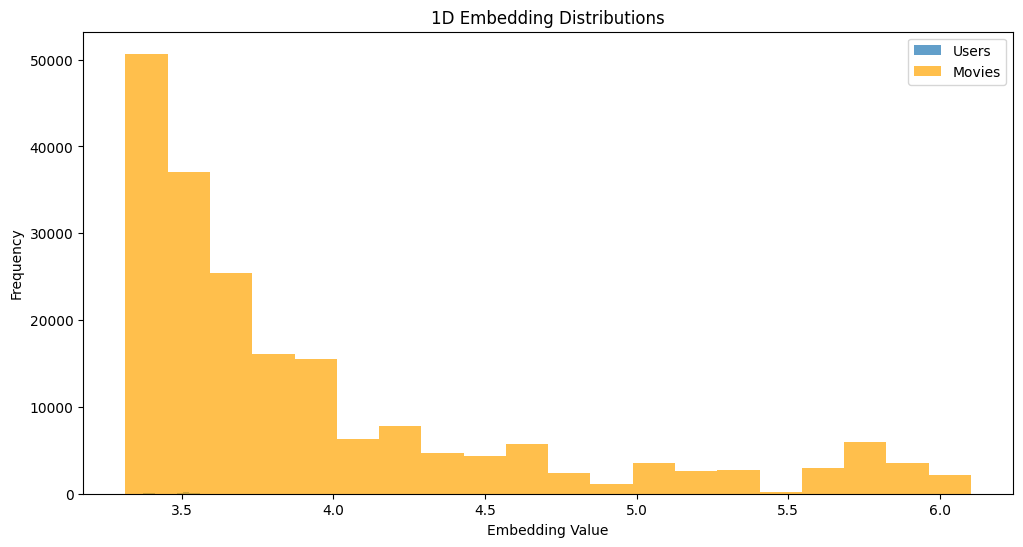

In [9]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

loss_history = []
rmse_history = []
accuracy_history = []

for epoch in range(20):
    model.train()
    total_loss = 0
    total_rmse = 0
    total_accuracy = 0
    for i, batch in enumerate(loader):
        batch = batch.to(device)
        optimizer.zero_grad()
        out = model(batch.x, batch.edge_index, batch.edge_attr)

        target = batch.edge_attr.view(-1, 1)
        loss = F.mse_loss(out, target)
        loss.backward()  
        optimizer.step()
        total_loss += loss.item()

        rmse = torch.sqrt(F.mse_loss(out, target)).item()
        total_rmse += rmse
        accuracy = (torch.abs(out - target) < 1.0).float().mean().item()
        total_accuracy += accuracy

    scheduler.step()

    # Append metrics
    loss_history.append(total_loss)
    rmse_history.append(total_rmse / len(loader))
    accuracy_history.append(total_accuracy / len(loader))

    print(f"Epoch {epoch+1}, Loss: {total_loss:.4f}, RMSE: {total_rmse/len(loader):.4f}, Accuracy: {total_accuracy/len(loader):.4f}")

plt.figure(figsize=(12, 4))

# Loss Plot
plt.subplot(1, 3, 1)
plt.plot(loss_history, label="Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(rmse_history, label="RMSE", color='orange')
plt.xlabel("Epochs")
plt.ylabel("RMSE")
plt.title("Training RMSE")
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(accuracy_history, label="Accuracy", color='green')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training Accuracy")
plt.legend()

plt.tight_layout()
plt.show()

user_embeddings_np = user_embeddings.cpu().numpy()
movie_embeddings_np = movie_embeddings.cpu().numpy()

plt.figure(figsize=(12, 6))
plt.hist(user_embeddings_np.flatten(), bins=20, alpha=0.7, label="Users")
plt.hist(movie_embeddings_np.flatten(), bins=20, alpha=0.7, label="Movies", color='orange')
plt.title("1D Embedding Distributions")
plt.xlabel("Embedding Value")
plt.ylabel("Frequency")
plt.legend()
plt.show()
